In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

In [2]:
cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
train = pd.read_csv('sales_train.csv')
sample_sub = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
items.item_category_id.unique()

array([40, 76, 55, 19, 30, 23, 37, 41, 57, 43, 78, 54, 49, 44, 45, 77, 73,
       31, 75, 58, 56, 38, 67, 59, 60, 74, 21, 28, 20, 24, 29, 70, 22, 32,
       62, 25, 72,  4, 63, 27, 18, 26, 64, 15, 68,  0,  2,  5,  1,  3,  6,
       35, 65, 14, 13, 10, 11, 12, 48, 71, 69,  7, 33, 34, 16, 66, 39, 52,
       46, 42, 61,  8, 80,  9, 17, 36, 47, 82, 81, 50, 51, 79, 53, 83],
      dtype=int64)

In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
# will join item_cat to train data
df1 = items[['item_category_id', 'item_id']]

In [12]:
data = train.merge(df1, how='left', on='item_id')

In [13]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


C:\Users\USER7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


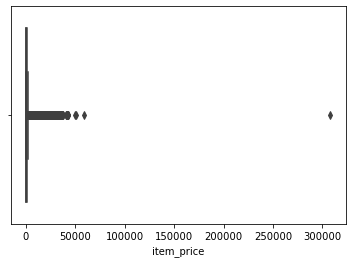

In [14]:
# reviewing the outlier of items prices
ax = sns.boxplot(data['item_price']) 
# hence will set the maximum for the item price 100,000, as 300,000 cannot even be due to plausible anomalies.

In [15]:
data = data[data['item_price']<100000]

In [16]:
data = data.reset_index().drop('index', axis=1)

C:\Users\USER7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


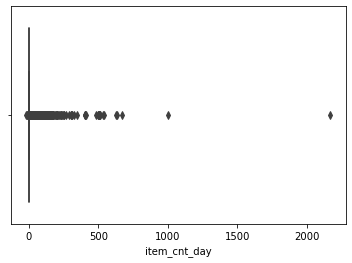

In [17]:
# reviewing the outlier of the number of products sold
ax = sns.boxplot(data['item_cnt_day']) 
# we can see that we have some negative values which has no meaning, the  other outliers can be due to plausible anomalies,as i am going to use LSTM it's not necessary to remove it.

In [18]:
data[data['item_cnt_day']>700]
# checked if that day with high sales is kind of cyclical event every year.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2326929,15.01.2015,24,12,20949,4.000000,1000.0,71
2909817,28.10.2015,33,12,11373,0.908714,2169.0,9


In [19]:
np.set_printoptions(formatter={'float': "{0:0}".format})
data['item_cnt_day'].unique() 

array([1.0, -1.0, 3.0, 2.0, 4.0, 5.0, 13.0, 7.0, 6.0, 8.0, 10.0, 11.0,
       30.0, 22.0, 14.0, 15.0, 9.0, 12.0, 17.0, 19.0, 20.0, -5.0, -6.0,
       -3.0, -2.0, 16.0, 64.0, 18.0, 29.0, 26.0, 39.0, 21.0, 27.0, 53.0,
       25.0, 23.0, 24.0, 40.0, 28.0, 31.0, 36.0, -4.0, 32.0, 35.0, 41.0,
       88.0, 44.0, 52.0, 56.0, 38.0, 34.0, 57.0, 69.0, 37.0, 47.0, 50.0,
       48.0, 33.0, 61.0, 80.0, 42.0, 82.0, 200.0, 100.0, 76.0, 77.0,
       107.0, 46.0, 49.0, 70.0, 55.0, 60.0, 45.0, 71.0, 65.0, 150.0, 85.0,
       89.0, 43.0, 58.0, 217.0, 104.0, 84.0, 168.0, 92.0, 156.0, 68.0,
       62.0, 264.0, 110.0, 83.0, 133.0, 51.0, 148.0, 54.0, 67.0, 106.0,
       109.0, 102.0, 90.0, 288.0, 171.0, 131.0, 87.0, 78.0, 151.0, 59.0,
       113.0, 118.0, 127.0, 97.0, 135.0, -22.0, 103.0, 111.0, 96.0, 242.0,
       105.0, 72.0, 126.0, 73.0, 101.0, 91.0, 63.0, 194.0, 255.0, 98.0,
       81.0, 75.0, 74.0, 121.0, 405.0, 99.0, 300.0, 401.0, 502.0, 138.0,
       134.0, 66.0, 240.0, 130.0, 115.0, 164.0, 112.0, 501

In [20]:
# removing the negative numbers and zero values in number of products sold.
train[train['item_cnt_day']<1].count()

date              7356
date_block_num    7356
shop_id           7356
item_id           7356
item_price        7356
item_cnt_day      7356
dtype: int64

In [21]:
data = data[data['item_cnt_day']>0]

C:\Users\USER7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


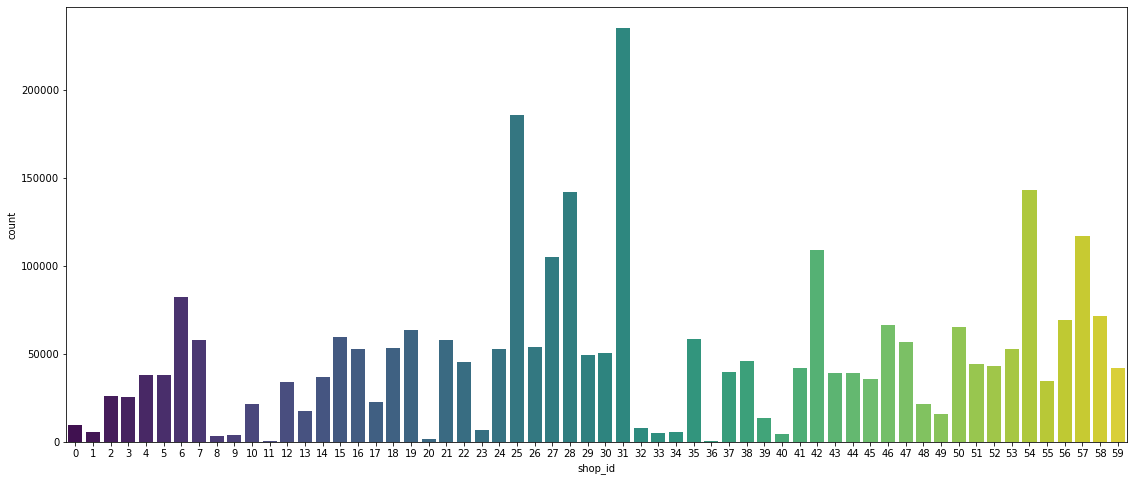

In [22]:
# finding the top sellers shops.
plt.figure(figsize=(19,8))
sns.countplot(data['shop_id'],palette='viridis')
plt.show()

In [109]:
#lst = [6, 25, 31, 42, 54, 57, 27, 28] # the top sellers shop names
shops[shops['shop_id'].isin([6, 25, 31, 42, 54, 57, 27, 28])]

,shop_name,shop_id
6,"Воронеж (Плехановская, 13)",6
25,"Москва ТРК ""Атриум""",25
27,"Москва ТЦ ""МЕГА Белая Дача II""",27
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28
31,"Москва ТЦ ""Семеновский""",31
42,"СПб ТК ""Невский Центр""",42
54,"Химки ТЦ ""Мега""",54
57,"Якутск Орджоникидзе, 56",57


In [112]:
items_count = pd.DataFrame(data['item_id'].value_counts()) # finding the top sellers items

In [117]:
top_items = items_count[items_count['item_id']>5000]

<AxesSubplot:ylabel='item_id'>

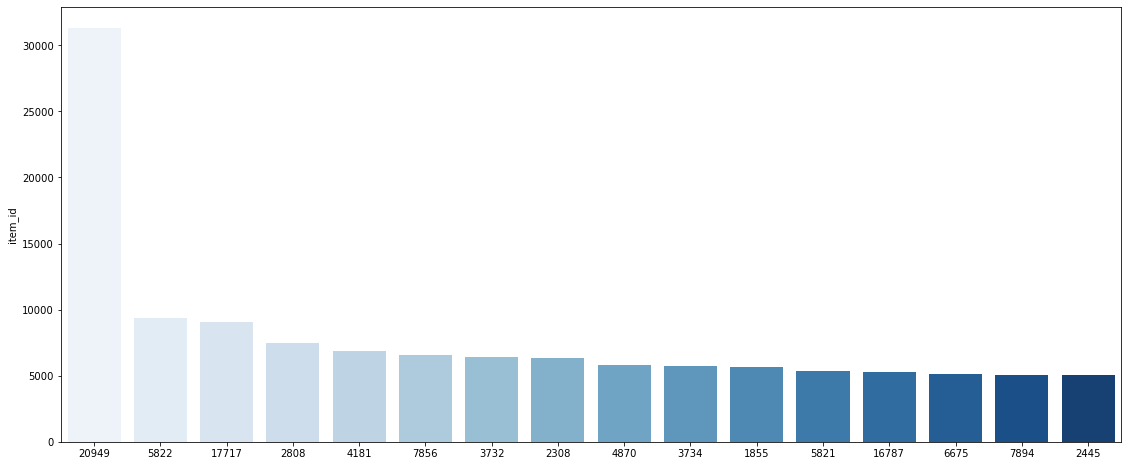

In [125]:
plt.figure(figsize=(19,8)) 
sns.barplot(x=top_items.index, y="item_id", data=top_items, palette = "Blues")

In [127]:
np.array(top_items['item_id'])

array([31337,  9404,  9067,  7470,  6850,  6598,  6451,  6310,  5788,
        5764,  5672,  5383,  5256,  5098,  5092,  5044], dtype=int64)

In [128]:
items[items['item_id'].isin([31337,  9404,  9067,  7470,  6850,  6598,  6451,  6310,  5788,
        5764,  5672,  5383,  5256,  5098,  5092,  5044])] # top items name

,item_name,item_id,item_category_id
5044,"NHL 16. Legacy Edition [Xbox 360, русские субт...",5044,23
5092,Nanoblock Бас-гитара,5092,67
5098,Nanoblock Божья коровка,5098,67
5256,"Need for Speed Shift 2 Unleashed [PS3, русская...",5256,19
5383,Office Home and Student 2016 Win Russian Russi...,5383,75
5672,PS4: Контроллер игровой беспроводной черный (D...,5672,3
5764,Pinnacle Studio 17 Plus ML (коробка),5764,75
5788,Planet mp3. Dance Collection (mp3-CD) (Jewel),5788,57
6310,SLIPKNOT Antennas To Hell CD+DVD (фирм.),6310,56
6451,"Silent Hill: Book of Memories [PS Vita, англий...",6451,22


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928492 entries, 0 to 2935847
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 178.7+ MB


<AxesSubplot:>

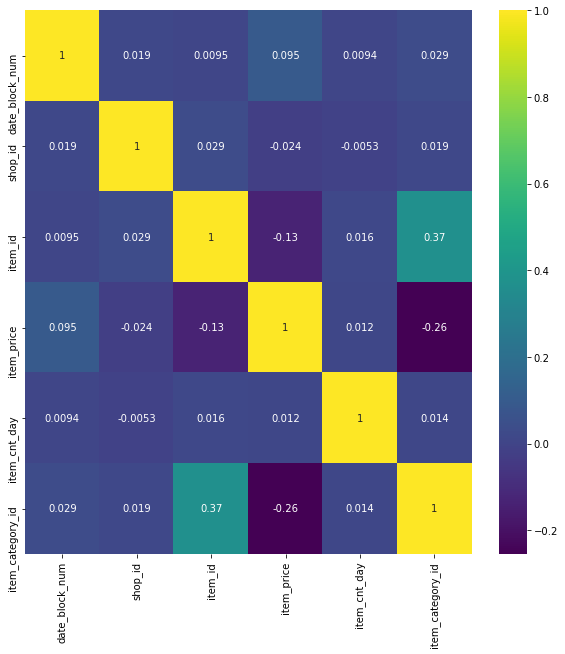

In [24]:
plt.figure(figsize=(10,10))

sns.heatmap(data.corr(),cmap='viridis',annot=True)

In [25]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2928492.0,14.569761,9.422953,0.0,7.0,14.0,23.0,33.0
shop_id,2928492.0,33.002959,16.225424,0.0,22.0,31.0,47.0,59.0
item_id,2928492.0,10200.280910,6324.396874,0.0,4477.0,9355.0,15691.0,22169.0
item_price,2928492.0,889.361584,1718.152833,-1.0,249.0,399.0,999.0,59200.0
item_cnt_day,2928492.0,1.248337,2.619586,1.0,1.0,1.0,1.0,2169.0
item_category_id,2928492.0,40.016343,17.098103,0.0,28.0,40.0,55.0,83.0


In [26]:
data.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [27]:
data.duplicated().sum()

6

In [28]:
data = data.drop_duplicates()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928486 entries, 0 to 2935847
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 178.7+ MB


In [30]:
data.shop_id = data.shop_id.astype('str')
data.item_id = data.item_id.astype('str')
data.item_category_id = data.item_category_id.astype('str')
data.date_block_num = data.date_block_num.astype('str')

In [31]:
df = data

In [32]:
def date_sep(df): # just for kaggle Monthly target
    """ grouping the sales in monthly basis """
    df = df.join(df['date'].str.split('.', expand=True).rename(columns={0:'D', 1:'M', 2:'Y'}))
    df['monthly_date'] = df['M']+'-'+df['Y']
    df = df.drop(['date','D','Y','M'],axis=1)
    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
    df = df.groupby(['item_id', 'shop_id', 'monthly_date'], as_index=False)['item_cnt_month'].sum()
    df.monthly_date = df.monthly_date.astype('datetime64[M]')
    return df

In [33]:
#df = date_sep(df)
df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
df = df.groupby(['item_id', 'shop_id', 'date'], as_index=False)['item_cnt_month'].sum()
df.date = df.date.astype('datetime64[D]')

In [34]:
df.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

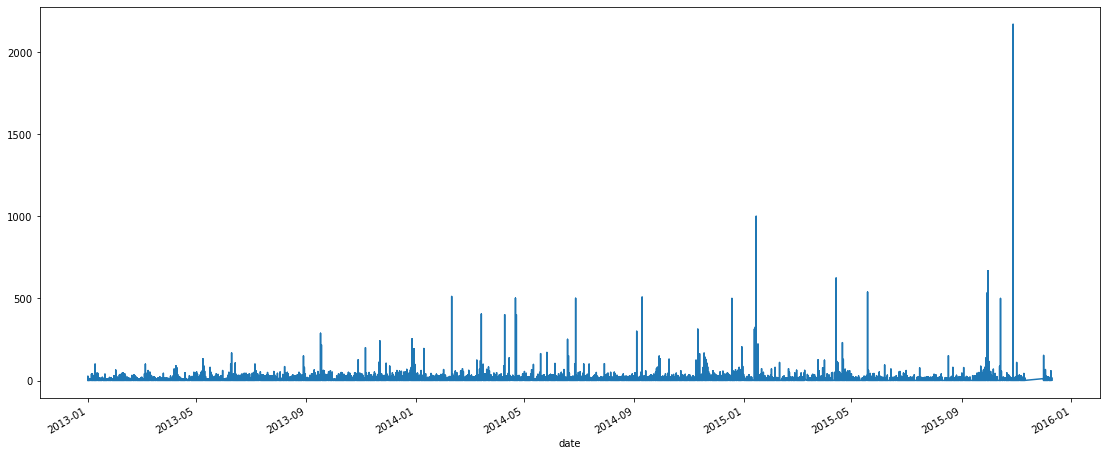

In [36]:
plt.figure(figsize = (19,8))
df['item_cnt_month'].plot()

In [67]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an monthly time series
    """
    
    return df[series_name][-(10000*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an monthly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'o')
    plt.title('{0} sales - {1} months'
              .format(series_name, n_days))
    plt.xlabel('Recorded months')
    plt.ylabel('sales')
    plt.grid(alpha=0.3)

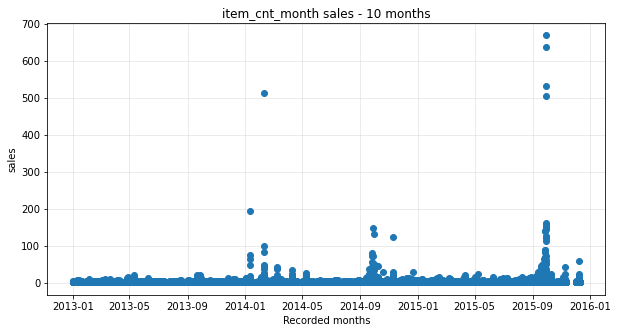

In [68]:
plot_n_last_days(df, 'item_cnt_month', 10)

In [39]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [79]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_months, 
                        test_months, sample_gap=300):
    """
    Utility processing function that splits an monthly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_months (int): length of sequence input to network 
    test_months (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_months] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_months:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_months, sample_gap): 
        train_X.append(train[i:i+input_months]) # each training sample is of length input hours
        train_y.append(train[i+input_months]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_months] 
    test_y = test[input_months:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [80]:
series_days = 1500000
input_months = 500
test_months = 1000

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'item_cnt_month', series_days, 
                         input_months, test_months))

In [83]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (9757, 500, 1)
Training output shape: (9757,)
Test input shape: (500,)
Test output shape: (500,)


In [84]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [85]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [86]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_months)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

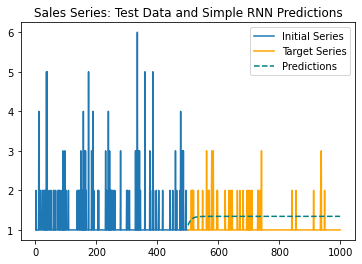

In [87]:
predict_and_plot(test_X_init, test_y, model,
                 'Sales Series: Test Data and Simple RNN Predictions')

In [88]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

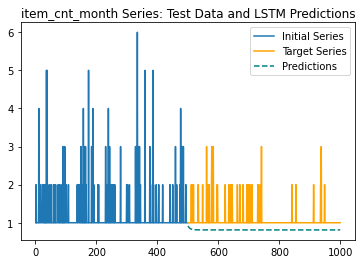

In [90]:
series_days = 1500000
input_months = 500
test_months = 1000

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'item_cnt_month', series_days, 
                         input_months, test_months))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=10) 

predict_and_plot(test_X_init, test_y, model, 
                 'item_cnt_month Series: Test Data and LSTM Predictions')